# Modelling DOM elements with Python class

One of the core feature of `manen` is to provide some classes that will allow to modelize most of the elements in a HTML page. This design pattern, known as Page Object Model, will allow you to have an easy interface between your application and the web interface. To quote [Martin Fowler](https://twitter.com/martinfowler):

> - A page object wraps an HTML page, or fragment, with an application-specific API, allowing you to manipulate page elements without digging around in the HTML.
> - A page object should also provide an interface that’s easy to program to and hides the underlying widgetry in the window page.
> - The page object should encapsulate the mechanics required to find and manipulate the data in the page itself. A good rule of thumb is to imagine changing the concrete page -in which case the page object interface shouldn’t change.

With `manen`, the page that you want to modelize will be represented by a class that inherits from `manen.page_object_model.Page`. All the elements inside this page will be represented by `manen.page_object_model.Elements` and its derivates.

Let's explore together how to apply the page object model design pattern by exploring the online PyPI page of `manen`.

## Basic DOM interacting

First things first, we need a WebDriver to be able to browse the Internet. Note that we will use here a `manen` browser but it will work the same with a Selenium WebDriver. Once initialized, we will go [PyPI home page](https://pypi.org).

In [1]:
from IPython.display import Image
from tempfile import NamedTemporaryFile
from manen.browser import ChromeBrowser
from manen import page_object_model as pom

In [2]:
browser = ChromeBrowser.initialize(proxy=None, headless=False, window_size=(1152, 864))
browser.get("https://pypi.org")

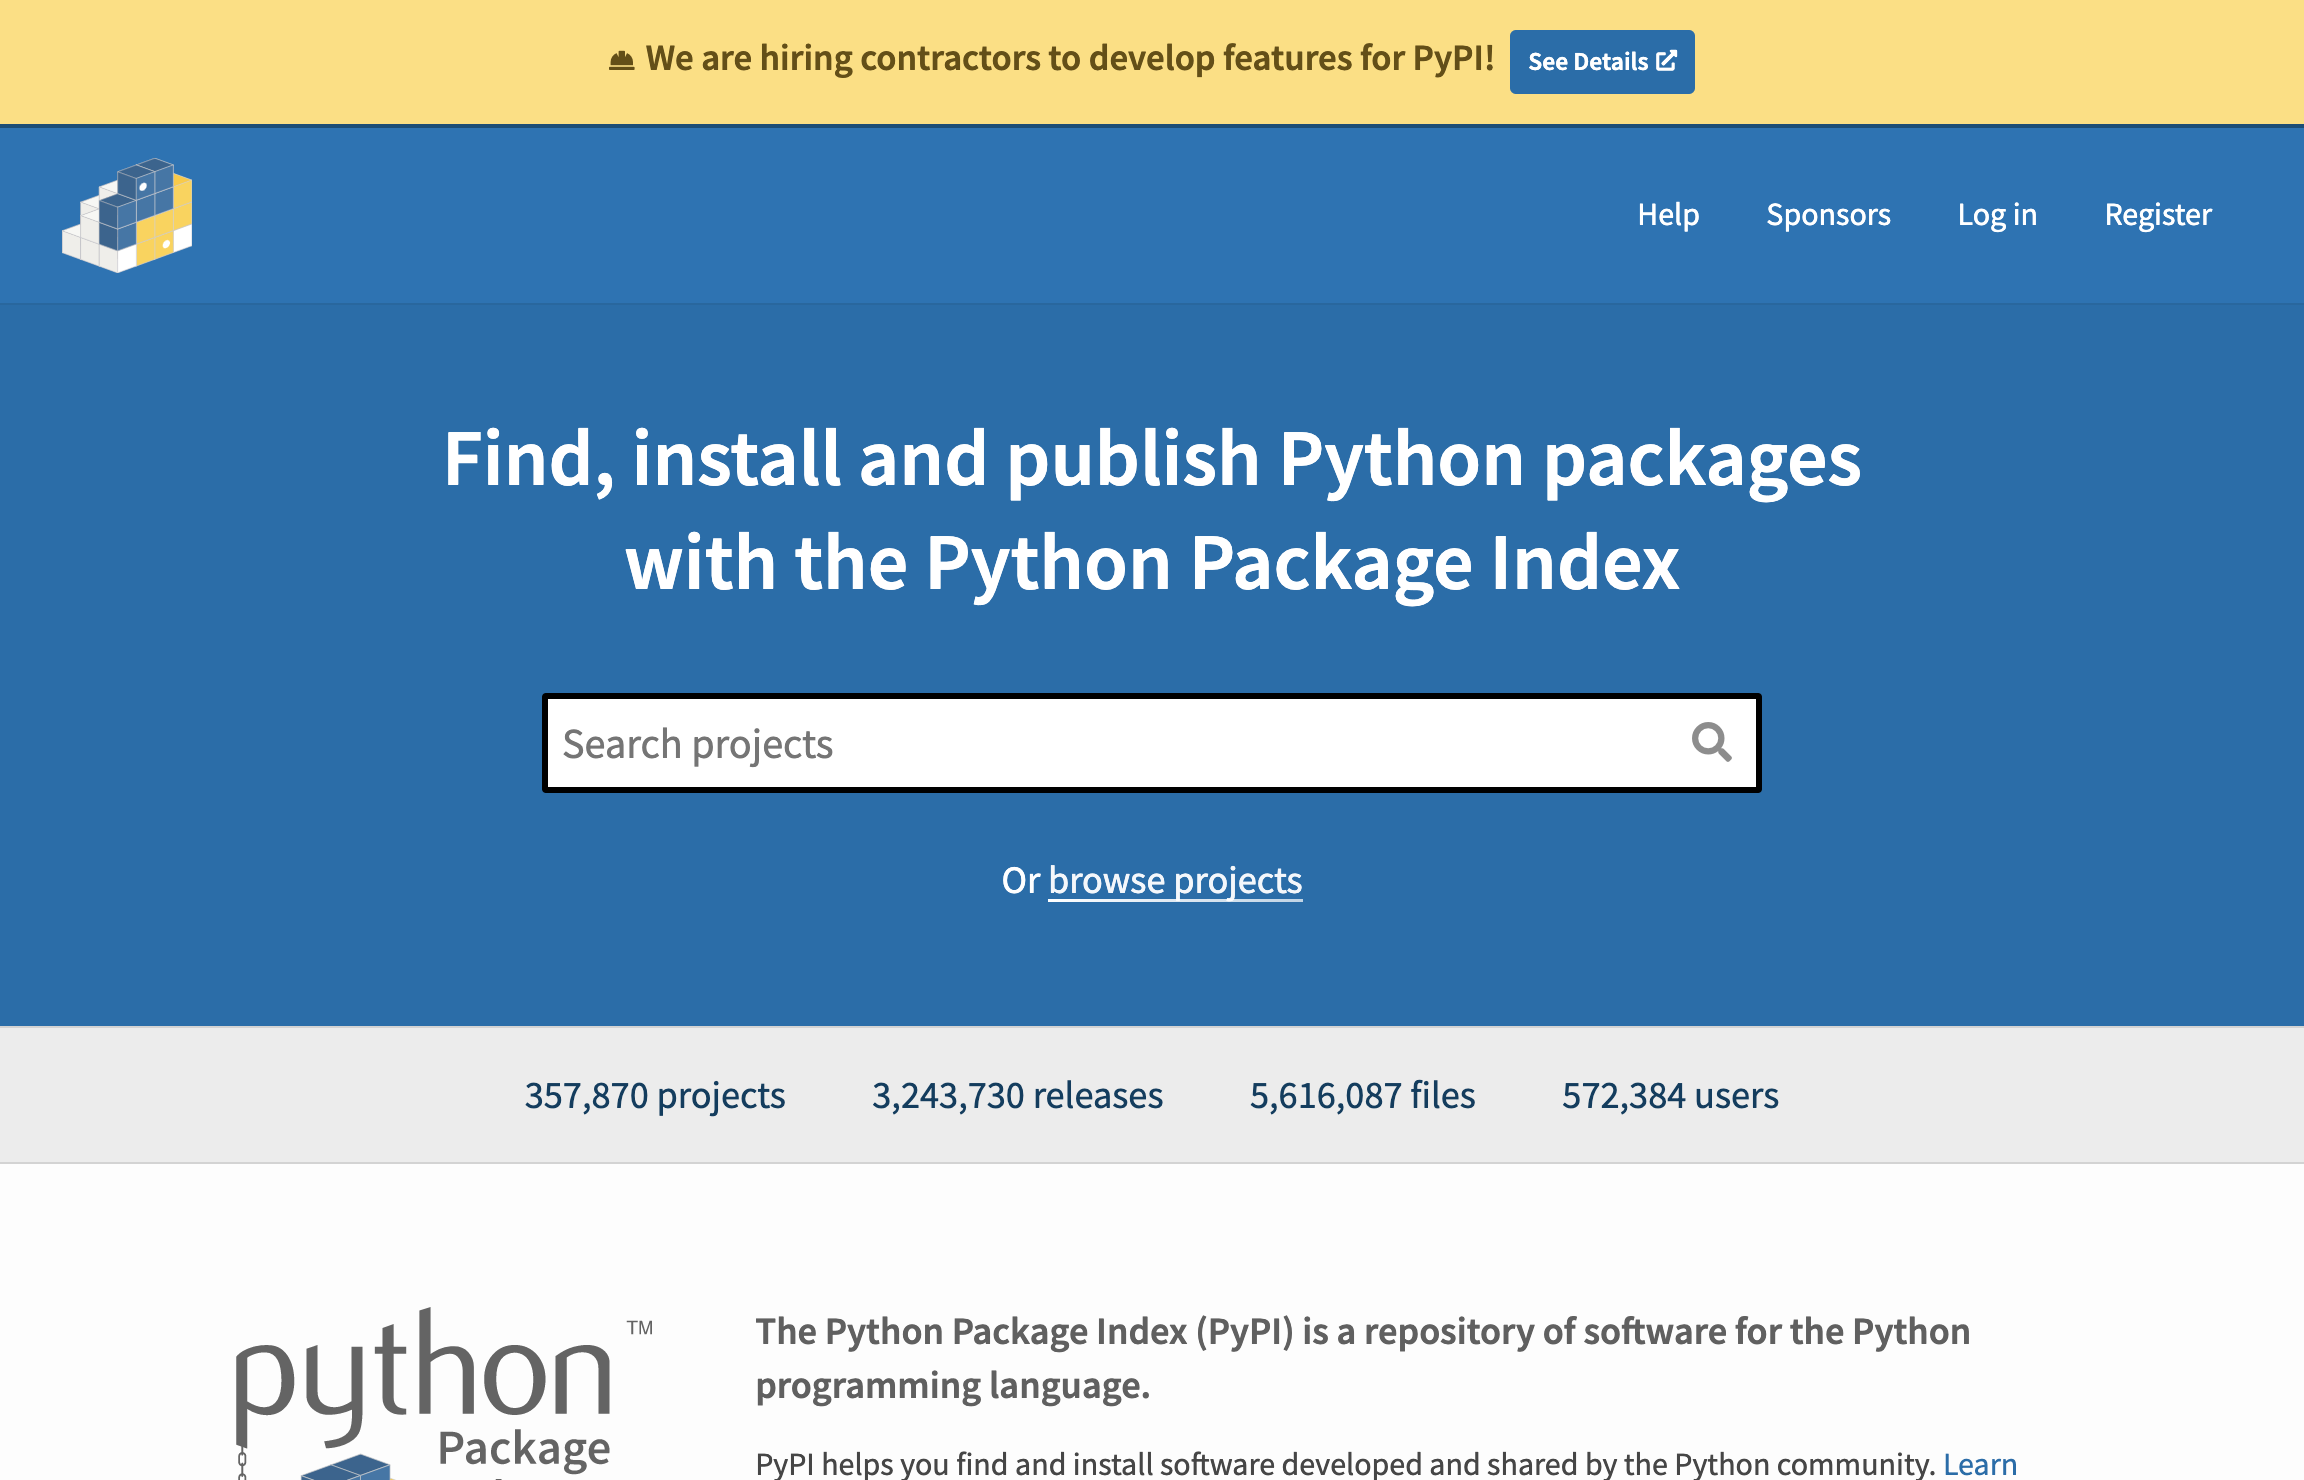

In [3]:
browser.highlight("input[id='search']")

with NamedTemporaryFile(suffix='.png') as f:
    browser.save_screenshot(f.name)
    screenshot = Image(f.name)
screenshot

What we want to do here is to be able to interact with the input search bar to fill it with the query `manen`. To do so, we will start by creating a `PyPIHomePage` class, inheriting from `HomePage`; all the attributes of this class will represent one element of the UI.

In order to represent the search bar as a `manen` element, we will use `InputElement`, that will allow us to easily fill a value inside. To initialize an element, you need to provide the selectors that will be used to identify the element inside the HTML source code. Note that instead of only one selector, you can specify a list of selectors: in this case, `manen` will try each selector until one returns a result.

Once the page is modelized, we have to create an instance by initializing it with the Browser or WebDriver used to navigate online.

In [4]:
class PyPIHomePage(pom.Page):
    query = pom.InputElement("input[id='search']")

page = PyPIHomePage(browser)

We can now interact directly with the search by simply setting a value to `page.query`; this is the goal of `manen`: having very Pythonic way to retrieve and interact with a HTML page.

In order to press *Enter*, you can use an `Action` that will trigger an event in the HTML page. Here by using `Action("submit")`, we submit the form and so launching a search inside PyPI.

In [5]:
page.query = "manen selenium"
page.query = pom.Action("submit")

We are now on the results page matching our query; let's modelize this page once again.

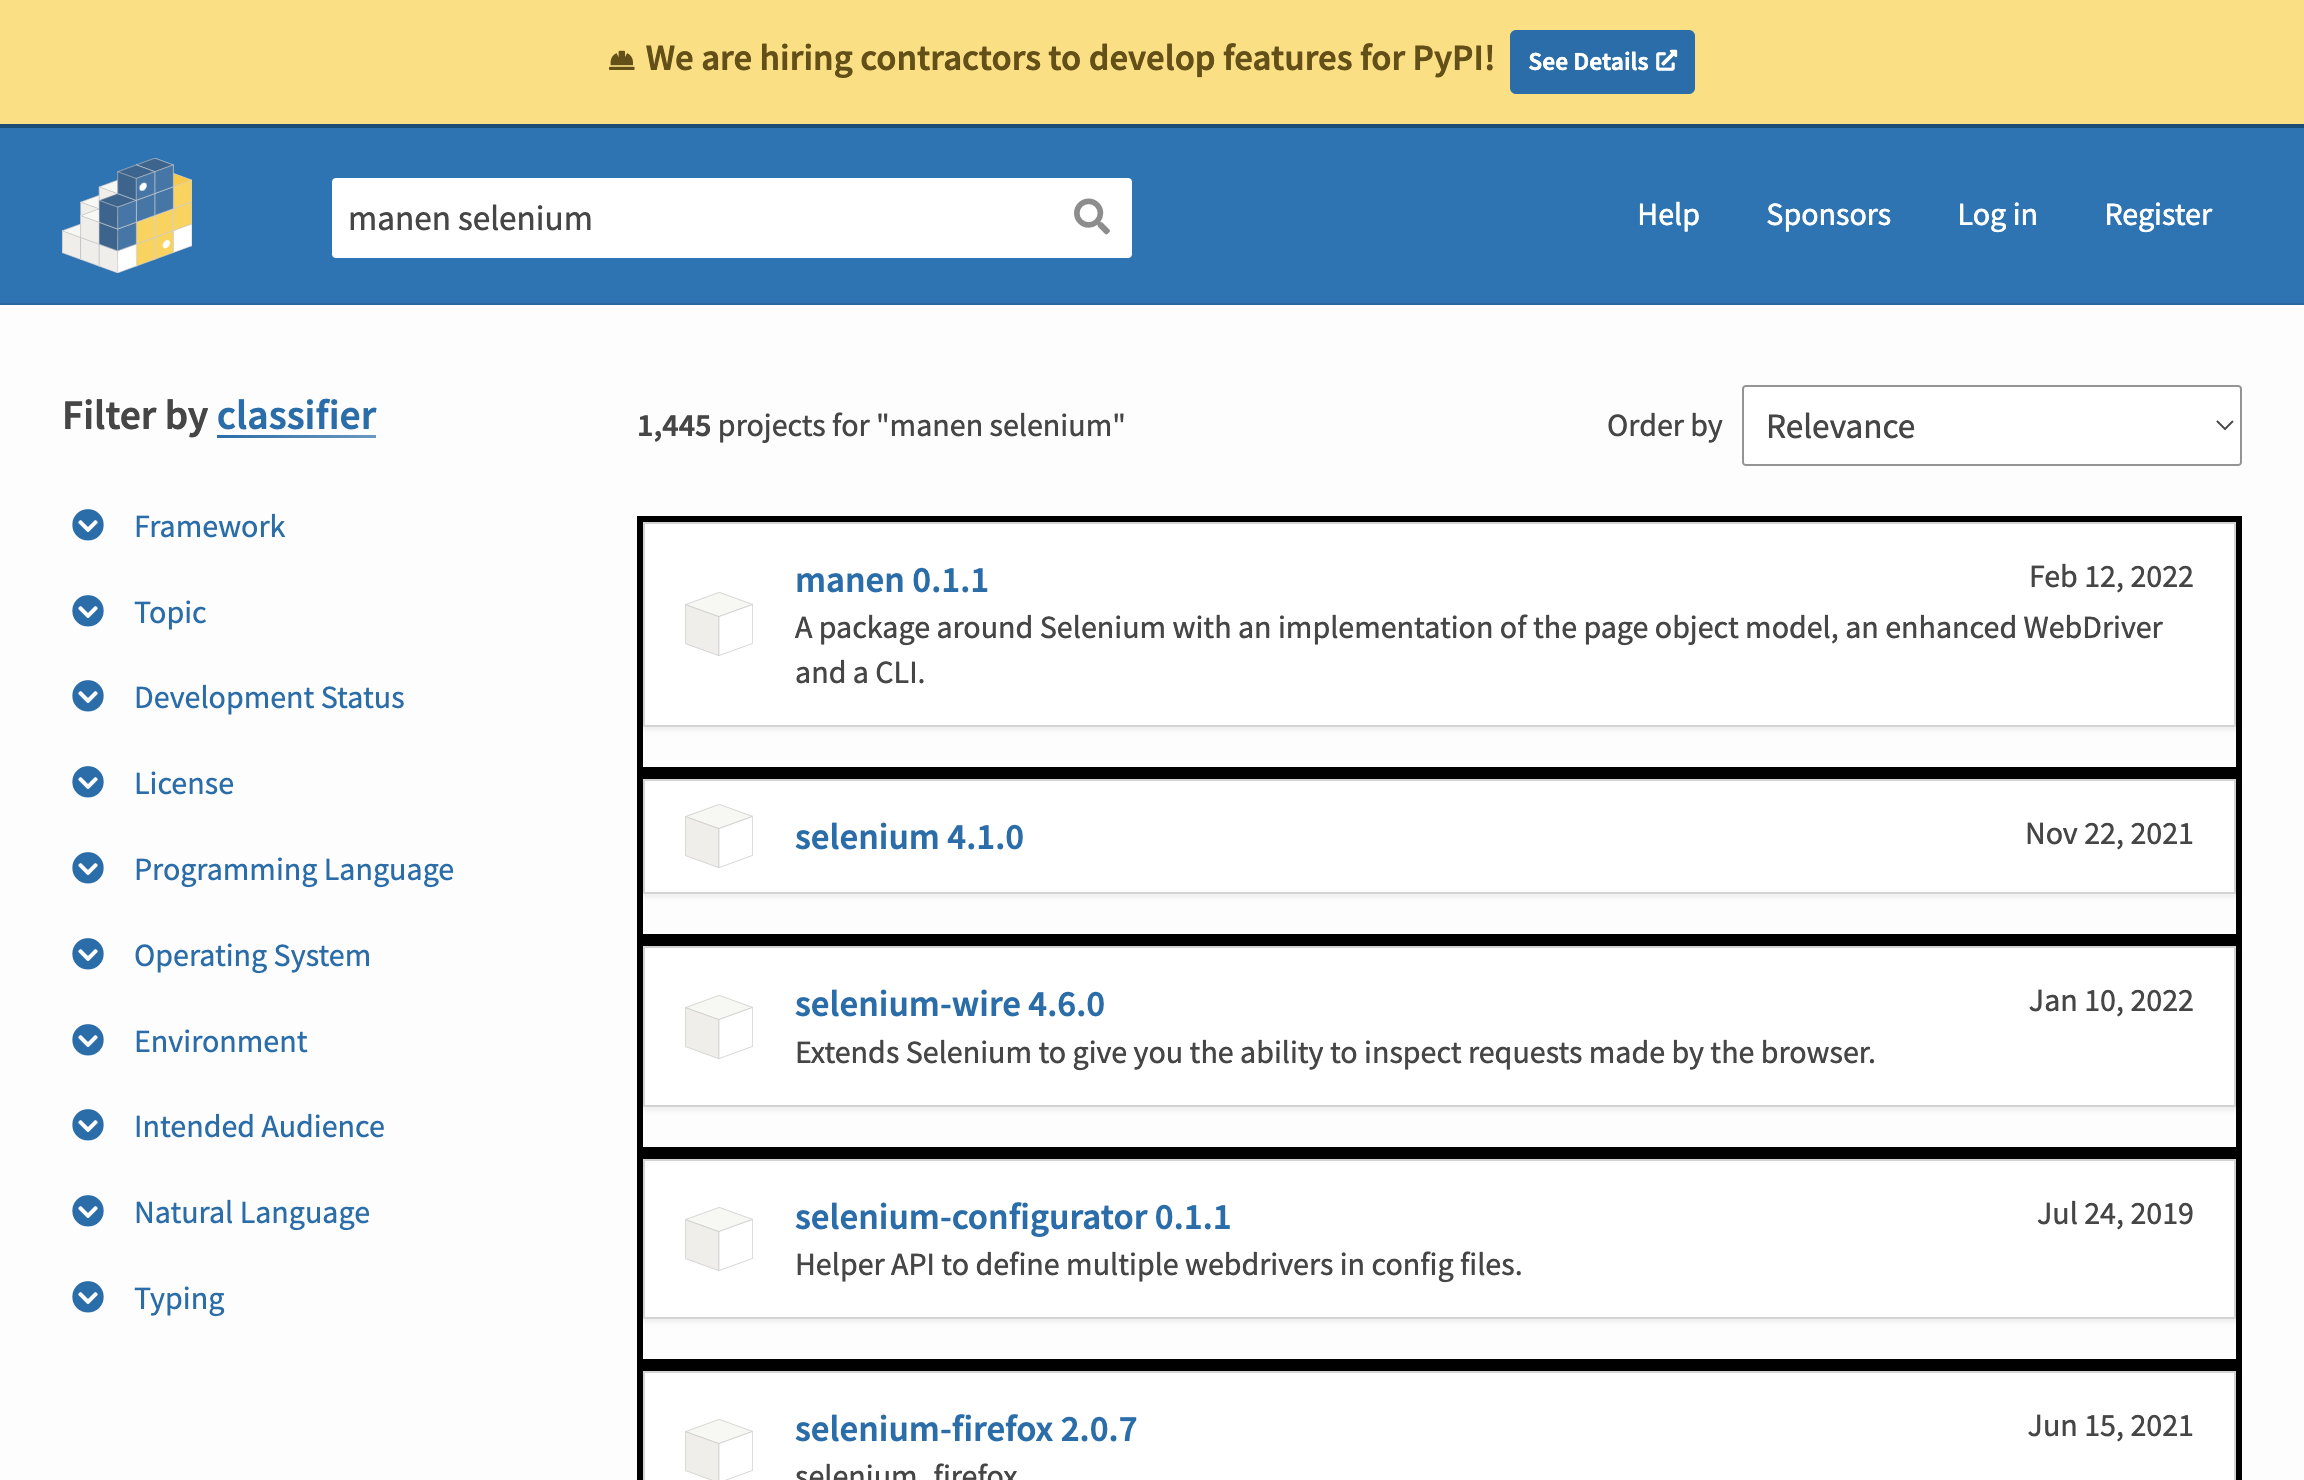

In [6]:
browser.highlight("ul[aria-label='Search results'] li")

with NamedTemporaryFile(suffix='.png') as f:
    browser.save_screenshot(f.name)
    screenshot = Image(f.name)
screenshot

This page can contain unique elements (like the number of results matching our query), but also some elements that can be repeated; this is for example the case for the result frames. Each frame has the same structure: in `manen`, this is called a region, represented with a `Region`. A region will itself contain several elements.

Inside each frame, we want to retrieve the information about a package like the name, URL, release date... Each of this piece of information can have its own type in Python (a string, a datetime, an integer...). `manen` provides several kind of elements that will extract the information for you; at the end, you will obtain directly what you need, preventing you to use methods of a Selenium WebElement to extract the real data you want.

Besides the selector(s), an `Element` can also be initialized with the following keyword arguments:

- `wait`: maximum number of seconds to wait until the element arrived in the HTML page
- `default`: default value to be returned if the element matches nothing in the HTML page

At the end, this search results page can be modelized as follow:

In [7]:
class SearchResultPage(pom.Page):
    class ResultRegions(pom.Regions):
        name = pom.TextElement("h3 span.package-snippet__name")
        version = pom.TextElement("h3 span.package-snippet__version")
        link = pom.LinkElement("a.package-snippet")
        description = pom.TextElement("p.package-snippet__description", default="(no description provided)")
        release_date = pom.DateTimeElement("span.package-snippet__released")

    n_results = pom.IntegerElement("//*[@id='content']//form/div[1]/div[1]/p/strong", wait=1)
    order_by = pom.SelectElement('select#order')
    results = ResultRegions("ul[aria-label='Search results'] li")

page = SearchResultPage(browser)

print("Number of results:", page.n_results)

Number of results: 1445


`page.results` will be a list of special classes, that will contain all the elements we have specified inside the region.

In [8]:
result = page.results[0]                    # type: ignore
result

In [9]:
print('Name:', result.name)                 # type: ignore
print('Version:', result.version)           # type: ignore
print('Release date:', result.release_date) # type: ignore
print('URL:', result.link)                  # type: ignore

Name: manen
Version: 0.1.1
Release date: 2022-02-12 00:00:00
URL: https://pypi.org/project/manen/


/Users/kodjo/.local/share/virtualenvs/manen-6kXEiGtM/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


`manen` provides a lot of different elements which are introduced in the next section.

In [10]:
browser.quit()

## List of available elements

`manen` provides out of the box a lot of different elements which can be used to modelize different tags/elements of a HTML page.

This section aims to list all of the element currently available and provide a quick introduction for some of them.

In [11]:
from manen.page_object_model import __all__
[elt for elt in __all__ if 'Element' in elt]

['CheckboxElement',
 'DateTimeElement',
 'DateTimeElements',
 'Element',
 'Elements',
 'ImageSourceElement',
 'ImageSourceElements',
 'InnerHtmlElement',
 'InnerHtmlElements',
 'InputElement',
 'IntegerElement',
 'IntegerElements',
 'LinkElement',
 'LinkElements',
 'OuterHtmlElement',
 'OuterHtmlElements',
 'RadioButtonElement',
 'SelectElement',
 'TextElement',
 'TextElements']

Note that most of the elements come in pair: the only difference between `...Element` and `...Elements` is that an `Element` will return only one result whereas an `Elements` will return a list of all the hits matching the selectors.

Here is a quick explanation of each elements:

| Name                    | Function                                                                                 |
|-------------------------|------------------------------------------------------------------------------------------|
| `Element(s)`            | Return the raw Selenium WebElement                                                       |
| `TextElement(s)`        | Extract the inner text of an element.                                                    |
| `IntegerElement(s)`     | Extract an integer of an element (the element can also contain text).                    |
| `DateTimeElement(s)`    | Extract the text and then infer a DateTime from its content.                             |
| `LinkElement(s)`        | Extract the `href` property of an `a` tag element.                                       |
| `ImageSourceElement(s)` | Return the `src` property of an image.                                                   |
| `InnerHTMLElement(s)`   | Return the raw HTML of all children elements.                                            |
| `InputElement`          | Modelize an input element in a form. Setting the value will fill the bar with the value. |
| `SelectElement`         | Return a Selenium `Select` object.                                                       |

Please refer to the code documentation for more information.